In [79]:
import pandas as pd
from datetime import datetime, timedelta
from pandas import Index
import numpy as np
from pytrends import request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pytrends.request import TrendReq

In [80]:
pm25_path    = "data/20180101_20180806-PA04C_auto.csv"
table=pd.read_csv(pm25_path ,sep=';').drop(0,axis=0)
table=table.rename(mapper={'heure':'hour'},axis=1)
table['date time'] = list(map(lambda stringdate,
         dhour: datetime.strptime(stringdate,'%d/%m/%Y').replace(hour=int(dhour)-1),
         table['date'],table['hour']))

In [81]:
def str2int(mstr):
    if mstr == 'n/d':
        return None
    else: return int(mstr)
table['PM25']=list(map(lambda mstr: str2int(mstr),table['PM25']))

In [82]:
table.to_csv("tempairparif.csv")

In [83]:
newest_datetime   = max(table['date time'])
earliest_datetime = min(table['date time'])

In [198]:
earliest_datetime

Timestamp('2018-01-01 00:00:00')

In [84]:
# ggtrend
pytrends = TrendReq(hl='En-US', tz=-120)
kw_list =  [pytrends.suggestions("air pollution")[0]['mid']]

In [85]:
ggtrend = pytrends.get_historical_interest(kw_list, 
                                 year_start=earliest_datetime.year,
                                          month_start=earliest_datetime.month, 
                                          day_start=earliest_datetime.days_in_month, 
                                          hour_start=earliest_datetime.hour, 
                                 year_end=newest_datetime.year,
                                          month_end=newest_datetime.month, 
                                          day_end=newest_datetime.days_in_month, 
                                          hour_end=newest_datetime.hour, 
                                 cat=0, # all categorical
                                          geo='FR-J',  # france ile-defrance
                                          gprop='',  # no specific group # image #hastag etc
                                          sleep=0)

The request failed: Google returned a response with code 500.
The request failed: Google returned a response with code 500.
The request failed: Google returned a response with code 500.


In [86]:
ggtrend.reset_index(inplace=True)

In [87]:
ggtrend.columns=Index(['date time', 'air pollution topic','isPartial'], dtype='object')

In [88]:
merged_t=table.merge(ggtrend,left_on='date time',right_on='date time')

In [102]:
merged_t=merged_t.fillna(method='ffill')

In [103]:
merged_t['air pollution topic']=merged_t['air pollution topic'].astype(np.int8)

In [187]:
date_index=(datetime(year=2018,month=6,day=15)< 
            merged_t['date time']) & (merged_t['date time']<datetime(year=2018,month=8,day=8))

# cross-correlation

In [188]:
def df_derived_by_shift(df,lag=0,NON_DER=[]):
    df = df.copy()
    if not lag:
        return df
    cols ={}
    for i in range(1,lag+1):
        for x in list(df.columns):
            if x not in NON_DER:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
    for k,v in cols.items():
        columns = v
        dfn = pd.DataFrame(data=None, columns=columns, index=df.index)    
        i = 1
        for c in columns:
            dfn[c] = df[k].shift(periods=i)
            i+=1
        df = pd.concat([df, dfn], axis=1, join_axes=[df.index])
    return df

In [200]:
cross_correlation=merged_t.loc[:,['air pollution topic','PM25']]

In [201]:
cross_correlation.to_csv("temp_parif.csv")

In [190]:
new_cross=df_derived_by_shift(cross_correlation,lag=6)

In [191]:
new_cross = new_cross.dropna()

In [192]:
new_cross.head()

,air pollution topic,PM25,air pollution topic_1,air pollution topic_2,air pollution topic_3,air pollution topic_4,air pollution topic_5,air pollution topic_6,PM25_1,PM25_2,PM25_3,PM25_4,PM25_5,PM25_6
3266,26,11.0,28.0,0.0,44.0,0.0,0.0,0.0,10.0,9.0,10.0,11.0,10.0,7.0
3267,18,13.0,26.0,28.0,0.0,44.0,0.0,0.0,11.0,10.0,9.0,10.0,11.0,10.0
3268,61,11.0,18.0,26.0,28.0,0.0,44.0,0.0,13.0,11.0,10.0,9.0,10.0,11.0
3269,10,11.0,61.0,18.0,26.0,28.0,0.0,44.0,11.0,13.0,11.0,10.0,9.0,10.0
3270,41,11.0,10.0,61.0,18.0,26.0,28.0,0.0,11.0,11.0,13.0,11.0,10.0,9.0


In [193]:
# from sklearn.preprocessing import scale

In [194]:
df_new =new_cross

In [195]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

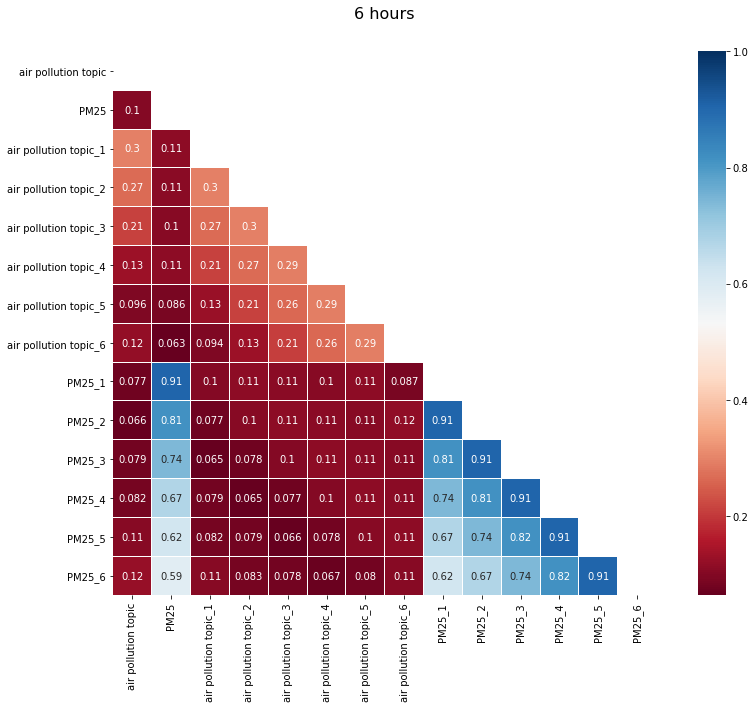

In [196]:
colormap = plt.cm.RdBu
plt.figure(figsize=(15,10))
plt.title(u'6 hours', y=1.05, size=16)

mask = np.zeros_like(df_new.corr())
mask[np.triu_indices_from(mask)] = True

svm = sns.heatmap(df_new.corr(), mask=mask, linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)